# Testing Human VAE

In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import *
import numpy as np
import os

import networks
from utils import *

torch.autograd.set_detect_anomaly(True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
tdm_ckpt = 'logs/2023/hh_20hz_3joints_xvel/tdm/models/tdm_final.pth' # input()

tdm_hyperparams = np.load(os.path.join(os.path.dirname(tdm_ckpt),'tdm_hyperparams.npz'), allow_pickle=True)
tdm_args = tdm_hyperparams['args'].item()
tdm_1 = networks.TDM(**(tdm_hyperparams['tdm_config'].item().__dict__)).to(device)
tdm_1.load_state_dict(torch.load(tdm_ckpt)['model_1'])
tdm_2 = networks.TDM(**(tdm_hyperparams['tdm_config'].item().__dict__)).to(device)
tdm_2.load_state_dict(torch.load(tdm_ckpt)['model_1'])
tdm_1.eval()
tdm_2.eval()

vae_hyperparams = np.load(os.path.join(os.path.dirname(tdm_args.vae_ckpt),'hyperparams.npz'), allow_pickle=True)
vae_args = vae_hyperparams['args'].item()
vae = getattr(networks, vae_args.model)(**(vae_hyperparams['vae_config'].item().__dict__)).to(device)

vae.load_state_dict(torch.load(tdm_args.vae_ckpt)['model'])
vae.eval()

with np.load(tdm_args.src, allow_pickle=True) as data:
	test_data_np = data['test_data']
	test_data = [torch.Tensor(traj) for traj in test_data_np]
	test_num = len(test_data)
	print(test_num,'Testing Trajecotries')
	lens = []
	for traj in test_data:
		lens.append(traj.shape[0])
	# padded_sequences = pad_sequence(test_data, batch_first=True, padding_value=1.)

39 Testing Trajecotries


In [3]:
# batch_size, seq_len, dims = padded_sequences.shape
# lens = torch.Tensor(lens)
# mask = torch.arange(seq_len).unsqueeze(0).repeat(batch_size,1) < lens.unsqueeze(1).repeat(1,seq_len)
x1_tdm = test_data[7][None,:,p1_tdm_idx].to(device)
x2_tdm = test_data[7][None,:,p2_tdm_idx].to(device)
x1_vae = test_data[7][None,:,p1_vae_idx].to(device)
x2_vae = test_data[7][None,:,p2_vae_idx].to(device)

x1_vae_out, z1_x1_samples, z1_x1_dist = vae(x1_vae)
x2_vae_out, z2_x2_samples, z2_x2_dist = vae(x2_vae)

z1_x1 = z1_x1_dist.mean
z2_x2 = z2_x2_dist.mean

# didn't fully understand how p(d|h_1) can be used to generate p(z_1|d) and p(z_2|d) 
# since the generated z_1 and z_2 (and x_1 and x_2) would belong to the same general distribution obtained from p(d|h_1)
#
# Is it the case that they have two separate AEs for each actor even in the HH case?
z1_d1_dist, d1_samples, d1_dist = tdm_1(x1_tdm, lens[7])
z2_d2_dist, d2_samples, d2_dist = tdm_2(x2_tdm, lens[7])

z1_d1 = z1_d1_dist.mean
z2_d2 = z2_d2_dist.mean
z2_d1 = tdm_2.output_mean(tdm_2._decoder(d1_dist.mean))

print(torch.allclose(z1_d1, z2_d1))

x1_tdm_out = vae._output(vae._decoder(z1_d1_dist.mean))
x2_tdm_out = vae._output(vae._decoder(z2_d1))


True


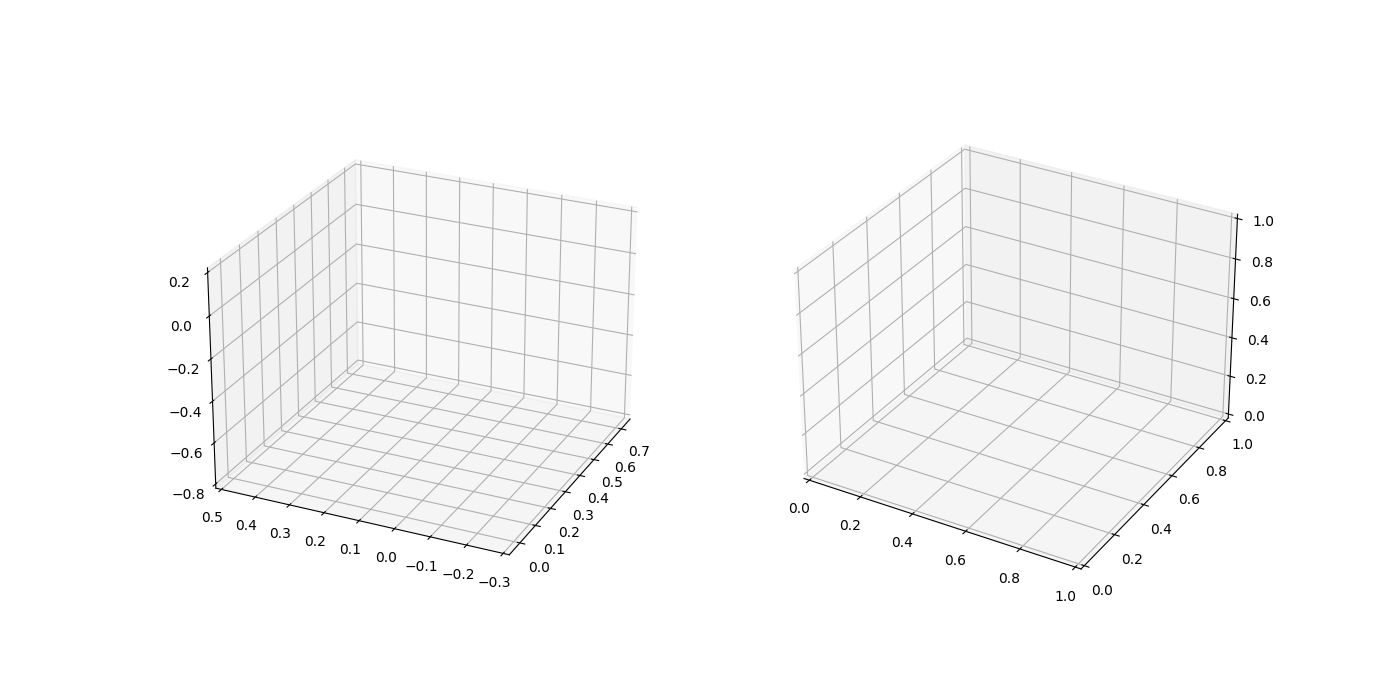

In [4]:
%matplotlib widget
import matplotlib.pyplot as plt
from utils import *
import asyncio

x1_vae_out = x1_vae_out.detach().cpu().numpy()[0].reshape((-1, 5, 3, 6))
x2_vae_out = x2_vae_out.detach().cpu().numpy()[0].reshape((-1, 5, 3, 6))

x2_tdm_out = x2_tdm_out.detach().cpu().numpy()[0].reshape((-1, 5, 3, 6))

z1_x1 = z1_x1.detach().cpu().numpy()[0]
z2_x2 = z2_x2.detach().cpu().numpy()[0]
z1_d1 = z1_d1.detach().cpu().numpy()[0]
z2_d2 = z2_d2.detach().cpu().numpy()[0]
z2_d1 = z2_d1.detach().cpu().numpy()[0]

fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(1,2,1, projection='3d')
# plt.ion()
ax.view_init(25, -155)
ax.set_xlim3d([-0.05, 0.75])
ax.set_ylim3d([-0.3, 0.5])
ax.set_zlim3d([-0.8, 0.2])
ax2 = fig.add_subplot(1,2,2, projection='3d')
async def update():
    global ax
    for i in range(7,8):
        N = test_data_np[i].shape[0]
        test_data = np.vstack([test_data_np[i][:, :90], test_data_np[i][:, 90:180]]).reshape((2*N, 5, 3, 6))
        # x2_gen = x2_tdm_out[i, :N].reshape((N, 40,4,3))
        
        z1_x1_i = z1_x1#[i, :N]
        z2_x2_i = z2_x2#[i, :N]
        z1_d1_i = z1_d1#[i, :N]
        z2_d2_i = z2_d2#[i, :N]
        z2_d1_i = z2_d1#[i, :N]
        for frame_idx in range(0,N,5):
            ax = reset_axis(ax)
            ax = visualize_skeleton(ax, test_data[frame_idx], markerfacecolor='r', linestyle='-')
            # ax = visualize_skeleton(ax, x1_vae_out[frame_idx], markerfacecolor='m', linestyle='--')
            # ax = visualize_skeleton(ax, x_gen[frame_idx], markerfacecolor='m', linestyle='--', alpha=0.2)

            test_data[N+frame_idx, ..., 0] = 0.7 - test_data[N+frame_idx, ..., 0]
            test_data[N+frame_idx, ..., 1] = 0.2 - test_data[N+frame_idx, ..., 1]
            x2_vae_out[frame_idx, ..., 0] = 0.7 - x2_vae_out[frame_idx, ..., 0]
            x2_vae_out[frame_idx, ..., 1] = 0.2 - x2_vae_out[frame_idx, ..., 1]
            x2_tdm_out[frame_idx, ..., 0] = 0.7 - x2_tdm_out[frame_idx, ..., 0]
            x2_tdm_out[frame_idx, ..., 1] = 0.2 - x2_tdm_out[frame_idx, ..., 1]

            ax = visualize_skeleton(ax, test_data[N+frame_idx], markerfacecolor='b', linestyle='-')
            ax = visualize_skeleton(ax, x2_tdm_out[frame_idx], markerfacecolor='c', linestyle='--')
            # ax = visualize_skeleton(ax, x2_gen[frame_idx], markerfacecolor='g', linestyle='--', alpha=0.2)

            ax2.scatter(z1_x1_i[frame_idx, 0], z1_x1_i[frame_idx, 1], z1_x1_i[frame_idx, 2], color='r', marker='o')
            ax2.scatter(z2_x2_i[frame_idx, 0], z2_x2_i[frame_idx, 1], z2_x2_i[frame_idx, 2], color='b', marker='o')
            ax2.scatter(z1_d1_i[frame_idx, 0], z1_d1_i[frame_idx, 1], z1_d1_i[frame_idx, 2], color='m', marker='o')
            ax2.scatter(z2_d2_i[frame_idx, 0], z2_d1_i[frame_idx, 1], z2_d1_i[frame_idx, 2], color='c', marker='^')
            
            fig.canvas.draw_idle()
            fig.canvas.flush_events()
            await asyncio.sleep(0.001)
loop = asyncio.get_event_loop()
loop.create_task(update());
